In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from yaml import safe_load
import os
from tqdm import tqdm
%matplotlib inline



In [2]:
filenames=[]
for file in os.listdir("C:/Users/mahes/OneDrive/Documents/Desktop/hey/t20s"):
     filenames.append(os.path.join("C:/Users/mahes/OneDrive/Documents/Desktop/hey/t20s",file))

In [199]:
filenames[0:5]

['C:/Users/mahes/OneDrive/Documents/Desktop/hey/t20s\\1001349.yaml',
 'C:/Users/mahes/OneDrive/Documents/Desktop/hey/t20s\\1001351.yaml',
 'C:/Users/mahes/OneDrive/Documents/Desktop/hey/t20s\\1001353.yaml',
 'C:/Users/mahes/OneDrive/Documents/Desktop/hey/t20s\\1004729.yaml',
 'C:/Users/mahes/OneDrive/Documents/Desktop/hey/t20s\\1007655.yaml']

In [200]:
df_final = pd.DataFrame()
counter = 1

# Columns you want to keep
wanted_cols = [
    "innings",
    "meta.data_version",
    "meta.created",
    "meta.revision",
    "info.outcome.bowl_out",
     "info.bowl_out",
    "info.supersubs.South Africa",
    "info.supersubs.New Zealand",
    "info.outcome.eliminator",
    "info.balls_per_over",
    "info.outcome.method",
    "info.official_venue",
    "info.match_type_number",
    "info.city",
    "info.dates",
    "info.gender",
    "info.match_type",
    "info.outcome.by.wickets",
    "info.outcome.by.runs",
    "info.outcome.winner",
    "info.overs",
    "info.player_of_match",
    "info.teams",
    "info.toss.winner",
    "info.toss.decision",
    "info.venue",
    
]

for file in tqdm(filenames):
    with open(file, 'r') as f:
        df = pd.json_normalize(safe_load(f))
        df['match_id'] = counter

        # Keep only wanted columns if they exist
        df = df[[c for c in wanted_cols if c in df.columns] + ['match_id']]

        df_final = pd.concat([df_final, df], ignore_index=True)
        counter += 1
import pandas as pd
from yaml import safe_load
from tqdm import tqdm

all_dfs = []
counter = 1  # optional: to track match_id

for file in tqdm(filenames):
    with open(file, 'r') as f:
        try:
            data = safe_load(f)  # Load YAML/JSON
            
            # Skip empty files
            if not data:
                continue

            # If it's a single dict, wrap it in a list
            if isinstance(data, dict):
                data = [data]

            # Ensure we only normalize if data is a list of dicts
            if isinstance(data, list) and all(isinstance(d, dict) for d in data):
                df = pd.json_normalize(data)
                df['match_id'] = counter
                all_dfs.append(df)
                counter += 1
            else:
                print(f"Skipped file {file}: unsupported structure {type(data)}")
        
        except Exception as e:
            print(f"Error in file {file}: {e}")

# Combine all dataframes into one
if all_dfs:
    final_df = pd.concat(all_dfs, ignore_index=True)
else:
    final_df = pd.DataFrame()

print("Final DataFrame shape:", final_df.shape)


  5%|████                                                                           | 233/4571 [00:42<13:13,  5.46it/s]


KeyboardInterrupt: 

In [ ]:
backup = df_final.copy()

In [ ]:
df_final['info.gender'].value_counts()

In [ ]:
df_final = df_final[df_final['info.gender'] == 'male']
df_final.drop(columns=['info.gender'],inplace=True)


In [ ]:
df_final['info.match_type'].value_counts()

In [209]:
import pickle
pickle.dump(df_final,open('dataset_t20.pkl','wb'))

In [7]:
import pickle
matches = pickle.load(open('dataset_t20.pkl','rb'))
matches.iloc[0]['innings'][0]['1st innings']['deliveries']

[{0.1: {'batsman': 'AJ Finch',
   'bowler': 'SL Malinga',
   'non_striker': 'M Klinger',
   'runs': {'batsman': 0, 'extras': 0, 'total': 0}}},
 {0.2: {'batsman': 'AJ Finch',
   'bowler': 'SL Malinga',
   'non_striker': 'M Klinger',
   'runs': {'batsman': 0, 'extras': 0, 'total': 0}}},
 {0.3: {'batsman': 'AJ Finch',
   'bowler': 'SL Malinga',
   'non_striker': 'M Klinger',
   'runs': {'batsman': 1, 'extras': 0, 'total': 1}}},
 {0.4: {'batsman': 'M Klinger',
   'bowler': 'SL Malinga',
   'non_striker': 'AJ Finch',
   'runs': {'batsman': 2, 'extras': 0, 'total': 2}}},
 {0.5: {'batsman': 'M Klinger',
   'bowler': 'SL Malinga',
   'non_striker': 'AJ Finch',
   'runs': {'batsman': 0, 'extras': 0, 'total': 0}}},
 {0.6: {'batsman': 'M Klinger',
   'bowler': 'SL Malinga',
   'non_striker': 'AJ Finch',
   'runs': {'batsman': 3, 'extras': 0, 'total': 3}}},
 {1.1: {'batsman': 'M Klinger',
   'bowler': 'KMDN Kulasekara',
   'non_striker': 'AJ Finch',
   'runs': {'batsman': 0, 'extras': 0, 'total': 

In [8]:
def get_player_out(info):
    wk = info.get("wicket", None)
    if wk is None:
        return "0"
    
    if isinstance(wk, dict):
        return wk.get("player_out", "0")
    
    if isinstance(wk, list) and len(wk) > 0:
        if isinstance(wk[0], dict):
            return wk[0].get("player_out", "0")
    
    return "0"


delivery_list = []

skip_ids = {75,108,150,180,268,360,443,458,584,748,982,1052,1111,1226,1345}

for idx, row in matches.iterrows():
    
    if idx+1 in skip_ids:
        continue
    
    match_id = idx + 1
    innings = row['innings'][0]['1st innings']
    batting_team = innings['team']
    deliveries = innings['deliveries']

    for ball in deliveries:
        ball_num = list(ball.keys())[0]
        info = ball[ball_num]

        delivery_list.append({
            "match_id": match_id,
            "teams": row["info.teams"],
            "batting_team": batting_team,
            "ball": ball_num,
            "batsman": info["batsman"],
            "bowler": info["bowler"],
            "runs": info["runs"]["total"],
            "player_dismissed": get_player_out(info),
            "city": row["info.city"],
            "venue": row["info.venue"]
        })

delivery_df = pd.DataFrame(delivery_list)


In [9]:
delivery_df

,match_id,teams,batting_team,ball,batsman,bowler,runs,player_dismissed,city,venue
0,1,"[Australia, Sri Lanka]",Australia,0.1,AJ Finch,SL Malinga,0,0,NaN,Melbourne Cricket Ground
1,1,"[Australia, Sri Lanka]",Australia,0.2,AJ Finch,SL Malinga,0,0,NaN,Melbourne Cricket Ground
2,1,"[Australia, Sri Lanka]",Australia,0.3,AJ Finch,SL Malinga,1,0,NaN,Melbourne Cricket Ground
3,1,"[Australia, Sri Lanka]",Australia,0.4,M Klinger,SL Malinga,2,0,NaN,Melbourne Cricket Ground
4,1,"[Australia, Sri Lanka]",Australia,0.5,M Klinger,SL Malinga,0,0,NaN,Melbourne Cricket Ground
...,...,...,...,...,...,...,...,...,...,...
27951,233,"[Bangladesh, West Indies]",West Indies,18.4,SE Rutherford,Shakib Al Hasan,0,0,Dhaka,"Shere Bangla National Stadium, Mirpur"
27952,233,"[Bangladesh, West Indies]",West Indies,18.5,SE Rutherford,Shakib Al Hasan,0,SE Rutherford,Dhaka,"Shere Bangla National Stadium, Mirpur"
27953,233,"[Bangladesh, West Indies]",West Indies,18.6,O Thomas,Shakib Al Hasan,0,0,Dhaka,"Shere Bangla National Stadium, Mirpur"
27954,233,"[Bangladesh, West Indies]",West Indies,19.1,SS Cottrell,Mahmudullah,1,0,Dhaka,"Shere Bangla National Stadium, Mirpur"


In [10]:
def bowl(row):
    for team in row['teams']:
        if team != row['batting_team']:
            return team

In [11]:
delivery_df['bowling_team'] = delivery_df.apply(bowl,axis=1)

In [12]:
delivery_df.drop(columns=['teams'],inplace=True)

In [13]:
delivery_df['batting_team'].unique()

array(['Australia', 'Hong Kong', 'Zimbabwe', 'India', 'Bangladesh',
       'New Zealand', 'South Africa', 'England', 'West Indies',
       'Sri Lanka', 'Pakistan', 'Scotland', 'Oman', 'Ireland',
       'Papua New Guinea', 'United Arab Emirates', 'Netherlands',
       'Thailand', 'Uganda', 'Malaysia'], dtype=object)

In [14]:
teams = [
    'Australia',
    'India',
    'Bangladesh',
    'New Zealand',
    'South Africa',
    'England',
    'West Indies',
    'Afghanistan',
    'Pakistan',
    'Sri Lanka'    
]

In [15]:
delivery_df = delivery_df[delivery_df['batting_team'].isin(teams)]
delivery_df = delivery_df[delivery_df['bowling_team'].isin(teams)]

In [16]:
delivery_df

,match_id,batting_team,ball,batsman,bowler,runs,player_dismissed,city,venue,bowling_team
0,1,Australia,0.1,AJ Finch,SL Malinga,0,0,NaN,Melbourne Cricket Ground,Sri Lanka
1,1,Australia,0.2,AJ Finch,SL Malinga,0,0,NaN,Melbourne Cricket Ground,Sri Lanka
2,1,Australia,0.3,AJ Finch,SL Malinga,1,0,NaN,Melbourne Cricket Ground,Sri Lanka
3,1,Australia,0.4,M Klinger,SL Malinga,2,0,NaN,Melbourne Cricket Ground,Sri Lanka
4,1,Australia,0.5,M Klinger,SL Malinga,0,0,NaN,Melbourne Cricket Ground,Sri Lanka
...,...,...,...,...,...,...,...,...,...,...
27951,233,West Indies,18.4,SE Rutherford,Shakib Al Hasan,0,0,Dhaka,"Shere Bangla National Stadium, Mirpur",Bangladesh
27952,233,West Indies,18.5,SE Rutherford,Shakib Al Hasan,0,SE Rutherford,Dhaka,"Shere Bangla National Stadium, Mirpur",Bangladesh
27953,233,West Indies,18.6,O Thomas,Shakib Al Hasan,0,0,Dhaka,"Shere Bangla National Stadium, Mirpur",Bangladesh
27954,233,West Indies,19.1,SS Cottrell,Mahmudullah,1,0,Dhaka,"Shere Bangla National Stadium, Mirpur",Bangladesh


In [17]:
total_df = delivery_df.groupby('match_id').sum()['runs'].reset_index()
delivery_df= delivery_df.merge(total_df,on='match_id')

In [18]:
delivery_df

,match_id,batting_team,ball,batsman,bowler,runs_x,player_dismissed,city,venue,bowling_team,runs_y
0,1,Australia,0.1,AJ Finch,SL Malinga,0,0,NaN,Melbourne Cricket Ground,Sri Lanka,168
1,1,Australia,0.2,AJ Finch,SL Malinga,0,0,NaN,Melbourne Cricket Ground,Sri Lanka,168
2,1,Australia,0.3,AJ Finch,SL Malinga,1,0,NaN,Melbourne Cricket Ground,Sri Lanka,168
3,1,Australia,0.4,M Klinger,SL Malinga,2,0,NaN,Melbourne Cricket Ground,Sri Lanka,168
4,1,Australia,0.5,M Klinger,SL Malinga,0,0,NaN,Melbourne Cricket Ground,Sri Lanka,168
...,...,...,...,...,...,...,...,...,...,...,...
19325,233,West Indies,18.4,SE Rutherford,Shakib Al Hasan,0,0,Dhaka,"Shere Bangla National Stadium, Mirpur",Bangladesh,190
19326,233,West Indies,18.5,SE Rutherford,Shakib Al Hasan,0,SE Rutherford,Dhaka,"Shere Bangla National Stadium, Mirpur",Bangladesh,190
19327,233,West Indies,18.6,O Thomas,Shakib Al Hasan,0,0,Dhaka,"Shere Bangla National Stadium, Mirpur",Bangladesh,190
19328,233,West Indies,19.1,SS Cottrell,Mahmudullah,1,0,Dhaka,"Shere Bangla National Stadium, Mirpur",Bangladesh,190


In [19]:
delivery_df['current_score'] = (
    delivery_df
    .groupby('match_id')['runs_x']
    .cumsum()
)



In [20]:

delivery_df['ball'] = delivery_df['ball'].astype(float)

# Extract over and ball_no correctly
delivery_df['over'] = delivery_df['ball'].apply(lambda x: int(x))
delivery_df['ball_no'] = delivery_df['ball'].apply(lambda x: min(6, int((x - int(x))*10 + 0.01)))  # Clip max 6

# Compute balls_bowled
delivery_df['balls_bowled'] = delivery_df['over']*6 + delivery_df['ball_no']



In [21]:
# Step 1: Clean dismissal column
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].astype(str).str.strip()

# Step 2: Correct wicket flag
delivery_df['wicket_flag'] = delivery_df['player_dismissed'].apply(lambda x: 1 if x not in ['0', '', 'nan', 'None'] else 0)

# Step 3: Sort
delivery_df = delivery_df.sort_values(['match_id', 'ball'])

# Step 4: FIX cumulative wickets (no +1, no -1, no modulo)
def cum_reset(series):
    cum = series.cumsum()
    return cum % 10    # reset to 0 after 10 wickets

delivery_df['wickets_fallen'] = delivery_df.groupby('match_id')['wicket_flag'].transform(cum_reset)

# Step 5: Correct wickets left
delivery_df['wickets_left'] = 10 - delivery_df['wickets_fallen']


In [22]:
delivery_df = delivery_df[['match_id','batting_team','bowling_team','runs_x','current_score','balls_bowled','ball','over','ball_no','wickets_left','city','runs_y']]

In [23]:
delivery_df.head(60)


,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,ball,over,ball_no,wickets_left,city,runs_y
0,1,Australia,Sri Lanka,0,0,1,0.1,0,1,10,NaN,168
1,1,Australia,Sri Lanka,0,0,2,0.2,0,2,10,NaN,168
2,1,Australia,Sri Lanka,1,1,3,0.3,0,3,10,NaN,168
3,1,Australia,Sri Lanka,2,3,4,0.4,0,4,10,NaN,168
4,1,Australia,Sri Lanka,0,3,5,0.5,0,5,10,NaN,168
5,1,Australia,Sri Lanka,3,6,6,0.6,0,6,10,NaN,168
6,1,Australia,Sri Lanka,0,6,7,1.1,1,1,10,NaN,168
7,1,Australia,Sri Lanka,1,7,8,1.2,1,2,10,NaN,168
8,1,Australia,Sri Lanka,0,7,9,1.3,1,3,10,NaN,168
9,1,Australia,Sri Lanka,0,7,10,1.4,1,4,10,NaN,168


In [24]:
delivery_df = delivery_df.sample(delivery_df.shape[0])

In [25]:
delivery_df['balls_left'] = 120 - delivery_df['balls_bowled']
delivery_df['balls_left'] = delivery_df['balls_left'].apply(lambda x:0 if x<0 else x)

In [26]:
delivery_df['crr'] = round((delivery_df['current_score']*6)/delivery_df['balls_bowled'],2)

In [27]:
delivery_df

,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,ball,over,ball_no,wickets_left,city,runs_y,balls_left,crr
13689,149,Australia,Pakistan,1,56,38,6.2,6,2,10,NaN,183,82,8.84
8401,88,West Indies,Sri Lanka,0,119,99,16.3,16,3,6,Antigua,154,21,7.21
2056,21,Australia,New Zealand,4,64,56,9.2,9,2,8,NaN,151,64,6.86
12105,122,New Zealand,West Indies,1,37,24,3.6,3,6,9,Mount Maunganui,167,96,9.25
15766,173,Bangladesh,West Indies,0,61,28,4.4,4,4,9,Lauderhill,184,92,13.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8824,92,South Africa,India,1,37,36,5.7,5,6,9,Potchefstroom,164,84,6.17
15715,172,Bangladesh,West Indies,0,139,98,16.2,16,2,6,Lauderhill,171,22,8.51
17532,217,Sri Lanka,Bangladesh,0,29,54,8.6,8,6,8,St Lucia,97,66,3.22
13535,147,Pakistan,Australia,0,9,10,1.4,1,4,9,NaN,194,110,5.40


In [28]:

delivery_df =delivery_df.sort_values(['match_id', 'batting_team', 'balls_bowled'])

delivery_df['runs_last_3_overs'] = (
    delivery_df.groupby(['match_id', 'batting_team'])['runs_x']
    .rolling(window=18, min_periods=1)  # use 1 for first balls so no NaN
    .sum()
    .reset_index(level=[0,1], drop=True)
)


In [29]:
delivery_df

,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,ball,over,ball_no,wickets_left,city,runs_y,balls_left,crr,runs_last_3_overs
0,1,Australia,Sri Lanka,0,0,1,0.1,0,1,10,NaN,168,119,0.00,0.0
1,1,Australia,Sri Lanka,0,0,2,0.2,0,2,10,NaN,168,118,0.00,0.0
2,1,Australia,Sri Lanka,1,1,3,0.3,0,3,10,NaN,168,117,2.00,1.0
3,1,Australia,Sri Lanka,2,3,4,0.4,0,4,10,NaN,168,116,4.50,3.0
4,1,Australia,Sri Lanka,0,3,5,0.5,0,5,10,NaN,168,115,3.60,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19325,233,West Indies,Bangladesh,0,189,112,18.4,18,4,2,Dhaka,190,8,10.12,17.0
19326,233,West Indies,Bangladesh,0,189,113,18.5,18,5,1,Dhaka,190,7,10.04,17.0
19327,233,West Indies,Bangladesh,0,189,114,18.6,18,6,1,Dhaka,190,6,9.95,13.0
19328,233,West Indies,Bangladesh,1,190,115,19.1,19,1,1,Dhaka,190,5,9.91,14.0


In [30]:
delivery_df= delivery_df[['match_id','batting_team','bowling_team','runs_x','current_score','balls_bowled','wickets_left','runs_last_3_overs','crr','city','runs_y']]

In [31]:
delivery_df

,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,wickets_left,runs_last_3_overs,crr,city,runs_y
0,1,Australia,Sri Lanka,0,0,1,10,0.0,0.00,NaN,168
1,1,Australia,Sri Lanka,0,0,2,10,0.0,0.00,NaN,168
2,1,Australia,Sri Lanka,1,1,3,10,1.0,2.00,NaN,168
3,1,Australia,Sri Lanka,2,3,4,10,3.0,4.50,NaN,168
4,1,Australia,Sri Lanka,0,3,5,10,3.0,3.60,NaN,168
...,...,...,...,...,...,...,...,...,...,...,...
19325,233,West Indies,Bangladesh,0,189,112,2,17.0,10.12,Dhaka,190
19326,233,West Indies,Bangladesh,0,189,113,1,17.0,10.04,Dhaka,190
19327,233,West Indies,Bangladesh,0,189,114,1,13.0,9.95,Dhaka,190
19328,233,West Indies,Bangladesh,1,190,115,1,14.0,9.91,Dhaka,190


In [32]:
delivery_df[delivery_df["match_id"]==664]

,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,wickets_left,runs_last_3_overs,crr,city,runs_y


In [33]:
delivery_df=delivery_df[delivery_df["balls_bowled"]>=18]
delivery_df

,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,wickets_left,runs_last_3_overs,crr,city,runs_y
17,1,Australia,Sri Lanka,0,19,18,10,19.0,6.33,NaN,168
18,1,Australia,Sri Lanka,0,19,19,10,19.0,6.00,NaN,168
19,1,Australia,Sri Lanka,1,20,20,10,20.0,6.00,NaN,168
20,1,Australia,Sri Lanka,1,21,21,10,20.0,6.00,NaN,168
21,1,Australia,Sri Lanka,1,22,22,10,19.0,6.00,NaN,168
...,...,...,...,...,...,...,...,...,...,...,...
19325,233,West Indies,Bangladesh,0,189,112,2,17.0,10.12,Dhaka,190
19326,233,West Indies,Bangladesh,0,189,113,1,17.0,10.04,Dhaka,190
19327,233,West Indies,Bangladesh,0,189,114,1,13.0,9.95,Dhaka,190
19328,233,West Indies,Bangladesh,1,190,115,1,14.0,9.91,Dhaka,190


In [34]:
delivery_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16524 entries, 17 to 19329
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   match_id           16524 non-null  int64  
 1   batting_team       16524 non-null  object 
 2   bowling_team       16524 non-null  object 
 3   runs_x             16524 non-null  int64  
 4   current_score      16524 non-null  int64  
 5   balls_bowled       16524 non-null  int64  
 6   wickets_left       16524 non-null  int64  
 7   runs_last_3_overs  16524 non-null  float64
 8   crr                16524 non-null  float64
 9   city               14667 non-null  object 
 10  runs_y             16524 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 1.5+ MB


In [35]:
delivery_df["runs_last_3_overs"]=delivery_df["runs_last_3_overs"].astype('int64')

C:\Users\mahes\AppData\Local\Temp\ipykernel_22220\1905329225.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df["runs_last_3_overs"]=delivery_df["runs_last_3_overs"].astype('int64')


In [36]:

delivery_df.describe(include="all")

,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,wickets_left,runs_last_3_overs,crr,city,runs_y
count,16524.000000,16524,16524,16524.000000,16524.000000,16524.000000,16524.000000,16524.000000,16524.000000,14667,16524.000000
unique,NaN,9,9,NaN,NaN,NaN,NaN,NaN,NaN,53,NaN
top,NaN,New Zealand,India,NaN,NaN,NaN,NaN,NaN,NaN,Colombo,NaN
freq,NaN,2575,2183,NaN,NaN,NaN,NaN,NaN,NaN,1576,NaN
mean,107.273178,NaN,NaN,1.292786,85.774752,68.381445,7.035827,22.764887,7.463238,NaN,155.605907
std,67.733244,NaN,NaN,1.546345,45.989476,29.667500,2.133231,8.693346,2.100640,NaN,39.629402
min,1.000000,NaN,NaN,0.000000,3.000000,18.000000,1.000000,2.000000,0.860000,NaN,59.000000
25%,51.000000,NaN,NaN,0.000000,49.000000,43.000000,6.000000,16.000000,6.000000,NaN,129.000000
50%,99.000000,NaN,NaN,1.000000,79.500000,68.000000,7.000000,22.000000,7.430000,NaN,155.000000
75%,157.000000,NaN,NaN,1.000000,117.000000,94.000000,9.000000,28.000000,8.800000,NaN,186.000000


In [37]:
delivery_df.isnull().sum()

match_id                0
batting_team            0
bowling_team            0
runs_x                  0
current_score           0
balls_bowled            0
wickets_left            0
runs_last_3_overs       0
crr                     0
city                 1857
runs_y                  0
dtype: int64

In [38]:
delivery_df = delivery_df.dropna(subset=['city'])


In [39]:
delivery_df

,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,wickets_left,runs_last_3_overs,crr,city,runs_y
143,2,Australia,Sri Lanka,0,18,18,9,18,6.00,Victoria,173
144,2,Australia,Sri Lanka,1,19,19,9,18,6.00,Victoria,173
145,2,Australia,Sri Lanka,2,21,20,9,20,6.30,Victoria,173
146,2,Australia,Sri Lanka,0,21,21,9,16,6.00,Victoria,173
147,2,Australia,Sri Lanka,4,25,22,9,19,6.82,Victoria,173
...,...,...,...,...,...,...,...,...,...,...,...
19325,233,West Indies,Bangladesh,0,189,112,2,17,10.12,Dhaka,190
19326,233,West Indies,Bangladesh,0,189,113,1,17,10.04,Dhaka,190
19327,233,West Indies,Bangladesh,0,189,114,1,13,9.95,Dhaka,190
19328,233,West Indies,Bangladesh,1,190,115,1,14,9.91,Dhaka,190


In [40]:
delivery_df.duplicated().sum()

np.int64(19)

In [41]:
delivery_df = delivery_df.drop_duplicates()


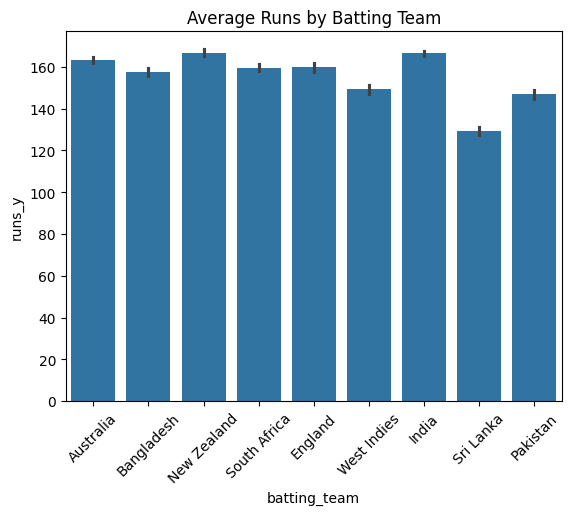

In [42]:
# DATA VISULAIZATION
sns.barplot(x='batting_team', y='runs_y', data=delivery_df, estimator='mean')
plt.xticks(rotation=45)
plt.title("Average Runs by Batting Team")
plt.show()



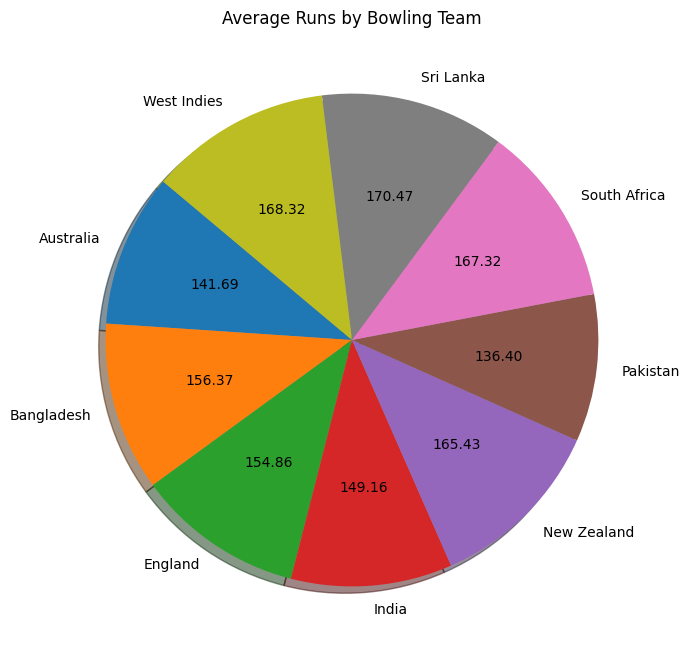

In [43]:
# Average runs per bowling team

avg_runs_per_team = delivery_df.groupby('bowling_team')['runs_y'].mean()

# Plot pie chart

plt.figure(figsize=(10,8))
avg_runs_per_team.plot(kind='pie', autopct=lambda pct: f"{pct * sum(avg_runs_per_team)/100:.2f}", startangle=140, shadow=True)
plt.title("Average Runs by Bowling Team")
plt.ylabel("")
plt.show()


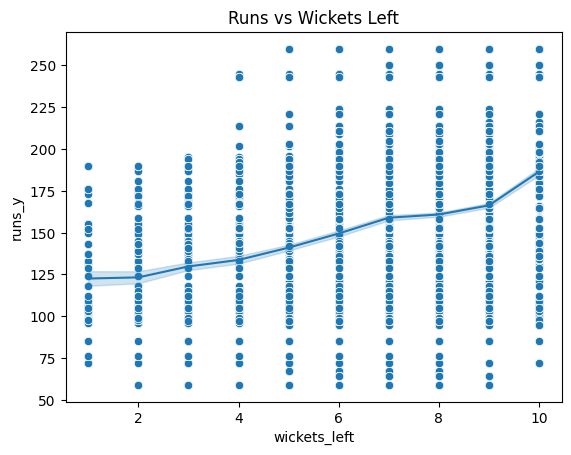

In [44]:
sns.scatterplot(x='wickets_left', y='runs_y', data=delivery_df)
sns.lineplot(x='wickets_left', y='runs_y', data=delivery_df, estimator='mean')
plt.title("Runs vs Wickets Left")
plt.show()


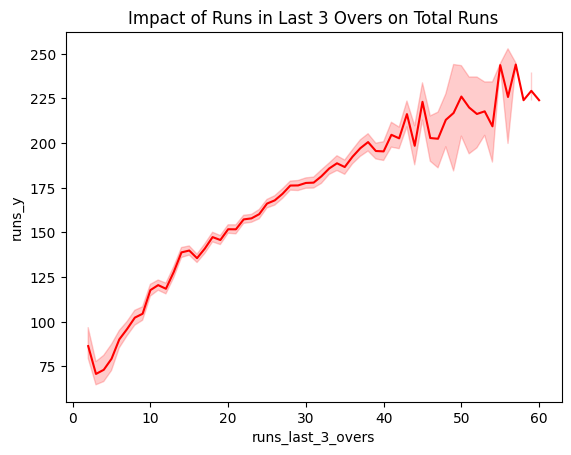

In [45]:
sns.lineplot(x='runs_last_3_overs', y='runs_y', data=delivery_df, color='red')
plt.title("Impact of Runs in Last 3 Overs on Total Runs")
plt.show()


In [46]:
delivery_df["city"].unique()

array(['Victoria', 'Napier', 'Mount Maunganui', 'Auckland', 'Southampton',
       'Taunton', 'Cardiff', 'Chester-le-Street', 'Kanpur', 'Nagpur',
       'Bangalore', 'Lauderhill', 'Colombo', 'Abu Dhabi', 'Nelson',
       'Bangkok', 'Hobart', 'Wellington', 'Hamilton', 'Bloemfontein',
       'Potchefstroom', 'Barbados', 'Trinidad', 'Sydney', 'Canberra',
       'Jamaica', 'Ranchi', 'Guwahati', 'Birmingham', 'Manchester',
       'Delhi', 'Rajkot', 'Thiruvananthapuram', 'Lahore', 'Johannesburg',
       'Centurion', 'Cape Town', 'Cuttack', 'Indore', 'Mumbai', 'Antigua',
       'East London', 'Bristol', 'Chelmsford', 'Dhaka', 'New Plymouth',
       'Karachi', 'Brisbane', 'St Kitts', 'Kuala Lumpur', 'Guyana',
       'St Lucia', 'Sylhet'], dtype=object)

In [47]:

# Sri Lanka
cities=['Colombo', 'Kandy', 'Dambulla', 'Hambantota',

# New Zealand
'Napier', 'Mount Maunganui', 'Auckland', 'Wellington', 'Hamilton', 'Christchurch', 'Dunedin', 'Nelson', 'Queenstown',

# Bangladesh
'Dhaka', 'Chattogram', 'Sylhet', 'Mirpur',

# England
'Southampton', 'Taunton', 'Cardiff', 'Chester-le-Street', 'Birmingham', 'Manchester', 'Nottingham', 'Leeds', 'Bristol', 'London',

# South Africa
'Bloemfontein', 'Potchefstroom', 'East London', 'Durban', 'Port Elizabeth', 'Gqeberha', 'Centurion', 'Cape Town', 'Paarl',

# India
'Kanpur', 'Nagpur', 'Bangalore', 'Bengaluru', 'Ranchi', 'Guwahati', 'Delhi', 'Rajkot', 'Thiruvananthapuram', 'Cuttack', 'Indore',
'Mumbai', 'Kolkata', 'Lucknow', 'Chennai', 'Visakhapatnam', 'Hyderabad', 'Chandigarh', 'Pune', 'Jaipur', 'Dharamsala',

# Pakistan
'Lahore', 'Karachi', 'Rawalpindi',

# Australia
'Hobart', 'Adelaide', 'Melbourne', 'Sydney', 'Canberra', 'Perth', 'Darwin', 'Cairns',

# West Indies / Caribbean
'Barbados', 'Trinidad', 'Jamaica', 'St Kitts', 'Gros Islet', 'Basseterre', 'Coolidge', 'Bridgetown', "St George's",
'Tarouba', 'Kingstown', 'St Lucia', 'Antigua', 'St Vincent', 'Providence', 'Guyana'
]


In [48]:
delivery_df = delivery_df[delivery_df["city"].isin(cities)]

In [49]:
delivery_df

,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,wickets_left,runs_last_3_overs,crr,city,runs_y
392,8,Bangladesh,New Zealand,1,12,18,9,12,4.00,Napier,141
393,8,Bangladesh,New Zealand,6,18,19,9,18,5.68,Napier,141
394,8,Bangladesh,New Zealand,0,18,20,9,18,5.40,Napier,141
395,8,Bangladesh,New Zealand,1,19,21,9,18,5.43,Napier,141
396,8,Bangladesh,New Zealand,0,19,22,9,16,5.18,Napier,141
...,...,...,...,...,...,...,...,...,...,...,...
19325,233,West Indies,Bangladesh,0,189,112,2,17,10.12,Dhaka,190
19326,233,West Indies,Bangladesh,0,189,113,1,17,10.04,Dhaka,190
19327,233,West Indies,Bangladesh,0,189,114,1,13,9.95,Dhaka,190
19328,233,West Indies,Bangladesh,1,190,115,1,14,9.91,Dhaka,190


In [50]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

delivery_df['batting_team'] = le.fit_transform(delivery_df['batting_team'])
delivery_df['bowling_team'] = le.fit_transform(delivery_df['bowling_team'])
delivery_df['city'] = le.fit_transform(delivery_df['city'])



In [51]:
print(delivery_df["batting_team"].unique())
print(delivery_df["bowling_team"].unique())
print(delivery_df["city"].unique())


[1 4 6 2 8 3 7 5 0]
[4 1 2 6 0 5 8 7 3]
[30 27  1 35 40  9 11 23 29  2 12 31 20 43 19  5 32  3 42 38  7 22 34 17
  4 26 14 33 41 25 10  8 13 21 28  0 16  6 15 24 36 18 37 39]


In [52]:
delivery_df

,match_id,batting_team,bowling_team,runs_x,current_score,balls_bowled,wickets_left,runs_last_3_overs,crr,city,runs_y
392,8,1,4,1,12,18,9,12,4.00,30,141
393,8,1,4,6,18,19,9,18,5.68,30,141
394,8,1,4,0,18,20,9,18,5.40,30,141
395,8,1,4,1,19,21,9,18,5.43,30,141
396,8,1,4,0,19,22,9,16,5.18,30,141
...,...,...,...,...,...,...,...,...,...,...,...
19325,233,8,1,0,189,112,2,17,10.12,15,190
19326,233,8,1,0,189,113,1,17,10.04,15,190
19327,233,8,1,0,189,114,1,13,9.95,15,190
19328,233,8,1,1,190,115,1,14,9.91,15,190


In [53]:
delivery_df=delivery_df.drop("match_id",axis=1)
delivery_df=delivery_df.drop("runs_x",axis=1)

In [54]:
# Train test split
from sklearn.model_selection import train_test_split
x=delivery_df.drop("runs_y",axis=1)
y=delivery_df["runs_y"]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)

In [55]:
x_train.shape

(9105, 8)

In [56]:
x_test.shape

(3036, 8)

In [57]:
update=delivery_df.copy()


In [58]:
x_train_update=x_train.copy()

In [59]:
x_test_update=x_test.copy()
y_train_update=y_train.copy()
y_test_update=y_test.copy()

In [60]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.fit_transform(x_test)

<Axes: >

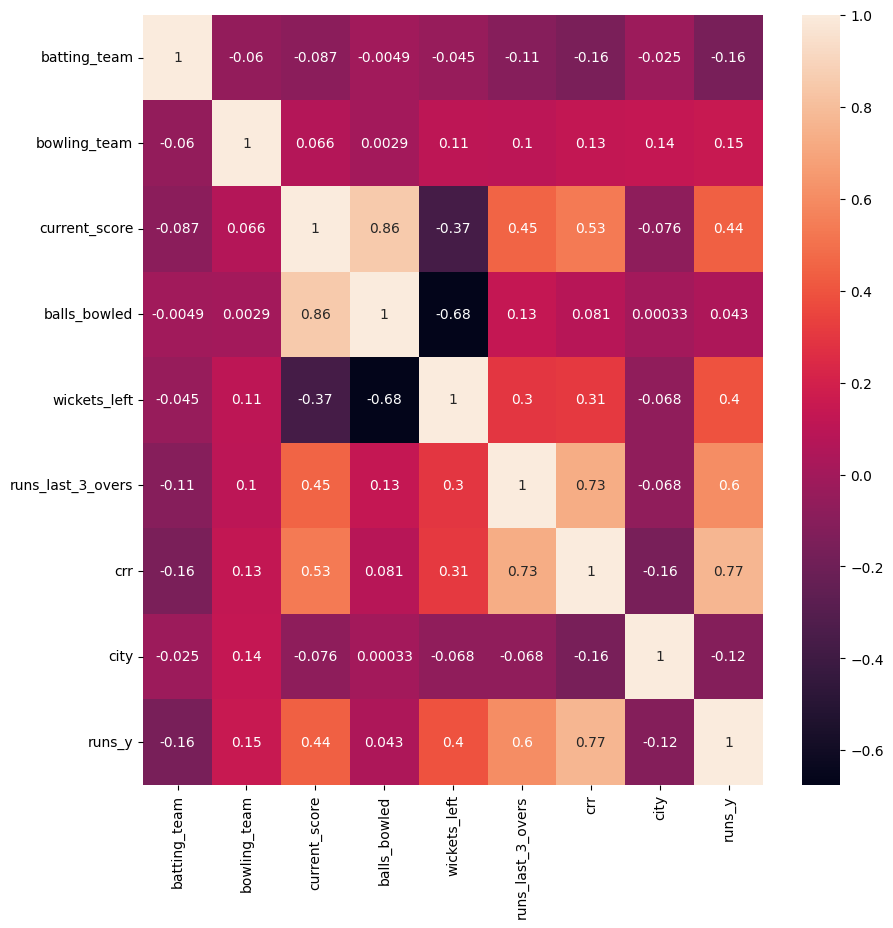

In [61]:
# feature engineering (best features)
plt.figure(figsize=(10,10))
sns.heatmap(delivery_df.corr(),annot=True)

In [62]:
# feature selection
from sklearn.feature_selection import mutual_info_classif
mutual=mutual_info_classif(x_train,y_train)
mutual
mutual=pd.Series(mutual)
mutual.index=x.columns
mutual.sort_values (ascending=False)

city                 2.968695
bowling_team         1.818561
batting_team         1.755125
crr                  1.129510
runs_last_3_overs    0.444035
wickets_left         0.435768
current_score        0.370026
balls_bowled         0.000000
dtype: float64

In [59]:
y_train.shape

(9105,)

In [60]:
x_train.shape

(9105, 8)

In [61]:
# x_train = x_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)



In [62]:
x_train

array([[ 1.72058884, -0.72211613,  0.3421659 , ...,  0.19702341,
         1.36661995, -0.74444545],
       [-0.86989672, -0.34324859, -1.09211093, ...,  1.23169936,
         0.45223526,  0.59828372],
       [-0.43814912,  0.79335405, -0.47130454, ..., -0.37779656,
        -0.14260639, -0.82342952],
       ...,
       [ 1.72058884,  1.17222159,  1.15563635, ..., -0.03290458,
        -0.10327802, -1.61327021],
       [-0.43814912, -0.72211613, -1.1777394 , ..., -0.03290458,
         0.30966991,  0.20336338],
       [-1.30164431, -0.34324859, -0.85663265, ...,  0.31198741,
        -0.11802616, -0.66546138]], shape=(9105, 8))

In [63]:
# Model training
# LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
lr=LinearRegression()
lr.fit(x_train,y_train)
lr_test_pred=lr.predict(x_test)
lr_train_pred=lr.predict(x_train)


In [64]:
lr_test_pred

array([170.30857758, 162.27229099, 188.72989945, ..., 125.73032326,
       133.930165  , 216.35680286], shape=(3035,))

In [65]:
mae_1 = mean_absolute_error(y_test, lr_test_pred)
mse_1 = mean_squared_error(y_test, lr_test_pred)
rmse_1 = np.sqrt(mse_1)
r2_1 = r2_score(y_test, lr_test_pred)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - lr_test_pred) ** 2)
see_1 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_1)
print("MSE:", mse_1)
print("RMSE:", rmse_1)
print("R2 Score:", r2_1)
print("Standard Error of Estimate (SEE):", see_1)


----- REGRESSION METRICS -----
MAE: 16.55859410465021
MSE: 527.0437966689037
RMSE: 22.957434453111343
R2 Score: 0.6677961152664578
Standard Error of Estimate (SEE): 22.991549374940313


In [66]:
train_mae = (mean_absolute_error(y_train, lr_train_pred))
test_mae = (mean_absolute_error(y_test, lr_test_pred))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")



Train MAE: 16.307320046060326
Test MAE: 16.55859410465021
Model is balanced.


In [67]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
param_lr={"fit_intercept":[True,False],"copy_X":[True,False],"n_jobs":[i for i in range(1,10)],"positive":[True,False]}
gc_lr=GridSearchCV(estimator=lr,param_grid=param_lr,cv=5,scoring="neg_mean_absolute_error")
gc_lr.fit(x_train,y_train)
print(gc_lr.best_params_)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'positive': False}


In [68]:
# after hyperparameter tuning
lr_tuned=LinearRegression(copy_X=True,fit_intercept=True,n_jobs=1,positive=False)
lr_tuned.fit(x_train,y_train)
y_lr_tuned_test=lr_tuned.predict(x_test)
y_lr_tuned_train=lr_tuned.predict(x_train)


In [69]:
#evaluatiom after tuning
mae_2 = mean_absolute_error(y_test, y_lr_tuned_test)
mse_2 = mean_squared_error(y_test, y_lr_tuned_test)
rmse_2 = np.sqrt(mse_2)
r2_2= r2_score(y_test, y_lr_tuned_test)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - y_lr_tuned_test) ** 2)
see_2 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_2)
print("MSE:", mse_2)
print("RMSE:", rmse_2)
print("R2 Score:", r2_2)
print("Standard Error of Estimate (SEE):", see_2)


----- REGRESSION METRICS -----
MAE: 16.55859410465021
MSE: 527.0437966689037
RMSE: 22.957434453111343
R2 Score: 0.6677961152664578
Standard Error of Estimate (SEE): 22.991549374940313


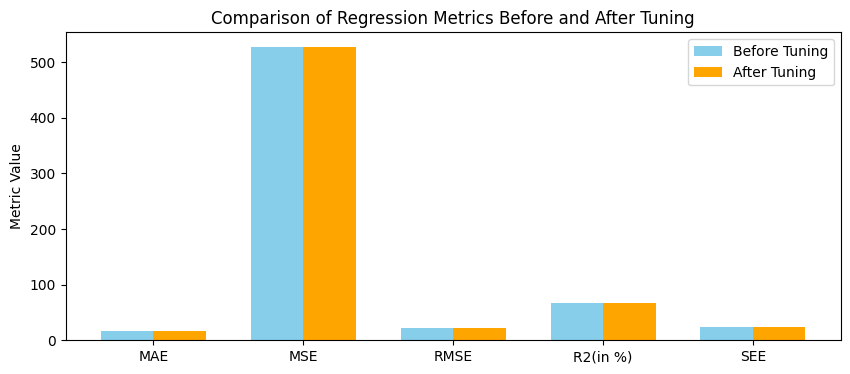

In [70]:
# Metrics
metrics = ['MAE', 'MSE', 'RMSE', 'R2(in %)', 'SEE']
before_values = [mae_1, mse_1, rmse_1, r2_1*100, see_1]
after_values  = [mae_2, mse_2, rmse_2, r2_2*100, see_2]

x = np.arange(len(metrics))  # label positions
width = 0.35  # width of bars

plt.figure(figsize=(10,4))
plt.bar(x - width/2, before_values, width, label='Before Tuning', color='skyblue')
plt.bar(x + width/2, after_values, width, label='After Tuning', color='orange')
plt.xticks(x, metrics)
plt.ylabel('Metric Value')
plt.title('Comparison of Regression Metrics Before and After Tuning')
plt.legend()
plt.show()

In [71]:
from sklearn.tree import DecisionTreeRegressor
dt=DecisionTreeRegressor()
dt.fit(x_train,y_train)
dt_test_pred=dt.predict(x_test)
dt_train_pred=dt.predict(x_train)
print(dt_test_pred)

[160. 153. 185. ...  96. 118. 250.]


In [72]:
mae_3 = mean_absolute_error(y_test, dt_test_pred)
mse_3 = mean_squared_error(y_test, dt_test_pred)
rmse_3 = np.sqrt(mse_3)
r2_3 = r2_score(y_test, dt_test_pred)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - dt_test_pred) ** 2)
see_3 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_3)
print("MSE:", mse_3)
print("RMSE:", rmse_3)
print("R2 Score:", r2_3)
print("Standard Error of Estimate (SEE):", see_3)

----- REGRESSION METRICS -----
MAE: 1.3116968698517297
MSE: 67.22932454695223
RMSE: 8.199349031901997
R2 Score: 0.9576243133423311
Standard Error of Estimate (SEE): 8.211533326791004


In [73]:
train_mae = (mean_absolute_error(y_train,dt_train_pred))
test_mae = (mean_absolute_error(y_test,dt_test_pred))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")


Train MAE: 0.004942339373970346
Test MAE: 1.3116968698517297
Model is OVERFITTING (High Variance).


In [282]:
# Hyperparameter tuning
param_dt={"max_depth":[i for i in range(1,10)],"min_samples_split":[j for j in range(1,5)],"min_samples_leaf":[m for m in range(1,5)] }
gc_dt=GridSearchCV(estimator=dt,param_grid=param_dt,cv=5)
gc_dt.fit(x_train,y_train)
print(gc_dt.best_params_)


{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 4}


C:\Users\mahes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mahes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mahes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\mahes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base

In [74]:
# after hyperparameter tuning
dt_tuned=DecisionTreeRegressor(max_depth=9, min_samples_leaf= 1, min_samples_split=4)
dt_tuned.fit(x_train,y_train)
dt_tuned_test=dt_tuned.predict(x_test)
dt_tuned_train=dt_tuned.predict(x_train)



In [75]:
#evaluatiom after tuning
mae_4 = mean_absolute_error(y_test, dt_tuned_test)
mse_4 = mean_squared_error(y_test, dt_tuned_test)
rmse_4 = np.sqrt(mse_4)
r2_4= r2_score(y_test, dt_tuned_test)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - dt_tuned_test) ** 2)
see_4 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_4)
print("MSE:", mse_4)
print("RMSE:", rmse_4)
print("R2 Score:", r2_4)
print("Standard Error of Estimate (SEE):", see_4)



----- REGRESSION METRICS -----
MAE: 6.464891439255365
MSE: 143.2410354856462
RMSE: 11.968334699766972
R2 Score: 0.9097129522397537
Standard Error of Estimate (SEE): 11.986119735962518


In [76]:
train_mae = (mean_absolute_error(y_train,dt_tuned_train))
test_mae = (mean_absolute_error(y_test,dt_tuned_test))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")


Train MAE: 5.882283724451212
Test MAE: 6.464891439255365
Model is balanced.


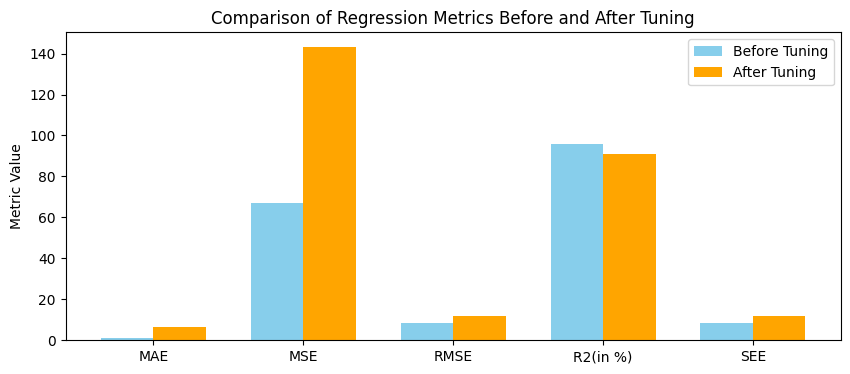

In [77]:
# Metrics
metrics = ['MAE', 'MSE', 'RMSE', 'R2(in %)', 'SEE']
before_values = [mae_3, mse_3, rmse_3, r2_3*100, see_3]
after_values  = [mae_4, mse_4, rmse_4, r2_4*100, see_4]

x = np.arange(len(metrics))  # label positions
width = 0.35  # width of bars

plt.figure(figsize=(10,4))
plt.bar(x - width/2, before_values, width, label='Before Tuning', color='skyblue')
plt.bar(x + width/2, after_values, width, label='After Tuning', color='orange')
plt.xticks(x, metrics)
plt.ylabel('Metric Value')
plt.title('Comparison of Regression Metrics Before and After Tuning')
plt.legend()
plt.show()

In [78]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf= RandomForestRegressor()
rf.fit(x_train,y_train)
rf_test_pred=rf.predict(x_test)
rf_train_pred=rf.predict(x_train)


In [79]:
rf_test_pred

array([163.47, 154.2 , 185.  , ..., 111.81, 120.74, 244.45], shape=(3035,))

In [80]:
mae_5 = mean_absolute_error(y_test, rf_test_pred)
mse_5 = mean_squared_error(y_test, rf_test_pred)
rmse_5 = np.sqrt(mse_5)
r2_5 = r2_score(y_test, rf_test_pred)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - rf_test_pred) ** 2)
see_5 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_5)
print("MSE:", mse_5)
print("RMSE:", rmse_5)
print("R2 Score:", r2_5)
print("Standard Error of Estimate (SEE):", see_5)

----- REGRESSION METRICS -----
MAE: 1.8404276771004944
MSE: 29.260425795565343
RMSE: 5.409290692462862
R2 Score: 0.9815566995007231
Standard Error of Estimate (SEE): 5.417328939484777


In [81]:
train_mae = (mean_absolute_error(y_train,rf_train_pred))
test_mae = (mean_absolute_error(y_test,rf_test_pred))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 0.749013179571664
Test MAE: 1.8404276771004944
Model is OVERFITTING (High Variance).


In [63]:
# ====== IMPORTS ======
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# ====== DEFINE ESTIMATOR ======
rf = RandomForestRegressor(random_state=42)

# ====== HYPERPARAMETER GRID ======
param_rf = {
    "n_estimators": [100, 200],
    "max_depth": [i for i in range(1, 5)]
}

# ====== GRID SEARCH ======
gc_rf = GridSearchCV(estimator=rf, param_grid=param_rf, cv=5)
gc_rf.fit(x_train, y_train)  # Make sure X_train and y_train exist
print("Best parameters:", gc_rf.best_params_)


Best parameters: {'max_depth': 4, 'n_estimators': 200}


In [82]:
# after hyperparameter tuning
rf_tuned=RandomForestRegressor(max_depth=9, n_estimators=800)
rf_tuned.fit(x_train,y_train)
rf_tuned_test=rf_tuned.predict(x_test)
rf_tuned_train=rf_tuned.predict(x_train)



In [83]:
#evaluatiom after tuning
mae_6 = mean_absolute_error(y_test, rf_tuned_test)
mse_6 = mean_squared_error(y_test, rf_tuned_test)
rmse_6 = np.sqrt(mse_6)
r2_6= r2_score(y_test, rf_tuned_test)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - rf_tuned_test) ** 2)
see_6 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_6)
print("MSE:", mse_6)
print("RMSE:", rmse_6)
print("R2 Score:", r2_6)
print("Standard Error of Estimate (SEE):", see_6)


----- REGRESSION METRICS -----
MAE: 6.542941631061788
MSE: 108.08748943195992
RMSE: 10.396513330533459
R2 Score: 0.9318707778986532
Standard Error of Estimate (SEE): 10.411962628245247


In [84]:

train_mae = (mean_absolute_error(y_train,rf_tuned_train))
test_mae = (mean_absolute_error(y_test,rf_tuned_test))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")


Train MAE: 5.867395742629878
Test MAE: 6.542941631061788
Model is balanced.


In [85]:
# XGBOOST
from xgboost import XGBRegressor
xg=XGBRegressor()
xg.fit(x_train,y_train)
xg_test_pred=xg.predict(x_test)
xg_train_pred=xg.predict(x_train)
print(xg_test_pred)

[159.96416 160.11668 169.40625 ...  92.80383 136.42532 177.24197]


In [86]:
mae_7 = mean_absolute_error(y_test, xg_test_pred)
mse_7 = mean_squared_error(y_test, xg_test_pred)
rmse_7 = np.sqrt(mse_7)
r2_7 = r2_score(y_test, xg_test_pred)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - xg_test_pred) ** 2)
see_7 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_7)
print("MSE:", mse_7)
print("RMSE:", rmse_7)
print("R2 Score:", r2_7)
print("Standard Error of Estimate (SEE):", see_7)

----- REGRESSION METRICS -----
MAE: 13.611061096191406
MSE: 368.31475830078125
RMSE: 19.191528295078047
R2 Score: 0.7678455114364624
Standard Error of Estimate (SEE): 19.220046289227337


In [87]:
train_mae = (mean_absolute_error(y_train,xg_train_pred))
test_mae = (mean_absolute_error(y_test,xg_test_pred))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 1.8654584884643555
Test MAE: 13.611061096191406
Model is OVERFITTING (High Variance).


In [298]:
# Hyperparameter tuning
param_xg={'n_estimators': [100, 200, 300,500,800],"max_depth":[ l for  l in range(1,3)],"learning_rate": [0.01, 0.05, 0.1, 0.2],"verbosity":[ r for r in range(0,3)] }
gc_xg=GridSearchCV(estimator=xg,param_grid=param_xg,cv=5)
gc_xg.fit(x_train,y_train)
print(gc_xg.best_params_)

[17:38:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (7283, 8, 58264).
[17:38:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (7283, 8, 58264).
[17:38:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (7283, 8, 58264).
[17:38:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (7283, 8, 58264).
[17:38:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (7284, 8, 58272).
[17:38:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (7283, 8, 58264).
[17:38:55] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iter

In [88]:
# after hyperparameter tuning
xg_tuned=XGBRegressor(learning_rate=0.01,max_depth=2,n_estimators=800,verbosity=0)
xg_tuned.fit(x_train,y_train)
xg_tuned_test=xg_tuned.predict(x_test)
xg_tuned_train=xg_tuned.predict(x_train)

In [89]:
#evaluatiom after tuning
mae_8 = mean_absolute_error(y_test, xg_tuned_test)
mse_8 = mean_squared_error(y_test, xg_tuned_test)
rmse_8 = np.sqrt(mse_8)
r2_8= r2_score(y_test, xg_tuned_test)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - xg_tuned_test) ** 2)
see_8 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_8)
print("MSE:", mse_8)
print("RMSE:", rmse_8)
print("R2 Score:", r2_8)
print("Standard Error of Estimate (SEE):", see_8)



----- REGRESSION METRICS -----
MAE: 16.034467697143555
MSE: 499.9179992675781
RMSE: 22.35884610769478
R2 Score: 0.6848939657211304
Standard Error of Estimate (SEE): 22.392071129351


In [90]:
train_mae = (mean_absolute_error(y_train,xg_tuned_train))
test_mae = (mean_absolute_error(y_test,xg_tuned_test))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")


Train MAE: 14.079107284545898
Test MAE: 16.034467697143555
Model is balanced.


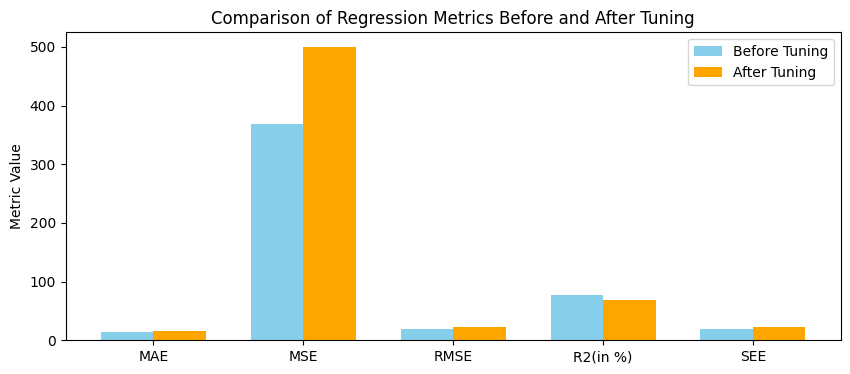

In [91]:
# Metrics
metrics = ['MAE', 'MSE', 'RMSE', 'R2(in %)', 'SEE']
before_values = [mae_7, mse_7, rmse_7, r2_7*100, see_7]
after_values  = [mae_8, mse_8, rmse_8, r2_8*100, see_8]

x = np.arange(len(metrics))  # label positions
width = 0.35  # width of bars

plt.figure(figsize=(10,4))
plt.bar(x - width/2, before_values, width, label='Before Tuning', color='skyblue')
plt.bar(x + width/2, after_values, width, label='After Tuning', color='orange')
plt.xticks(x, metrics)
plt.ylabel('Metric Value')
plt.title('Comparison of Regression Metrics Before and After Tuning')
plt.legend()
plt.show()

In [92]:
from sklearn.neighbors import KNeighborsRegressor
kn=KNeighborsRegressor()
kn.fit(x_train,y_train)
kn_test_pred=kn.predict(x_test)
kn_train_pred=kn.predict(x_train)
print(kn_test_pred)

[160. 153. 185. ...  96. 118. 250.]


In [93]:
mae_11 = mean_absolute_error(y_test, kn_test_pred)
mse_11= mean_squared_error(y_test, kn_test_pred)
rmse_11 = np.sqrt(mse_11)
r2_11 = r2_score(y_test, kn_test_pred)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - kn_test_pred) ** 2)
see_11 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_11)
print("MSE:", mse_11)
print("RMSE:", rmse_11)
print("R2 Score:", r2_11)
print("Standard Error of Estimate (SEE):", see_11)

----- REGRESSION METRICS -----
MAE: 1.0523887973640857
MSE: 26.096052718286654
RMSE: 5.108429574564639
R2 Score: 0.9835512529622424
Standard Error of Estimate (SEE): 5.116020739682021


In [94]:
train_mae = (mean_absolute_error(y_train,kn_train_pred))
test_mae = (mean_absolute_error(y_test,kn_test_pred))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 0.7533443163097198
Test MAE: 1.0523887973640857
Model is balanced.


In [314]:
# Hyperparameter tuning
param_kn={"n_neighbors":[5,10,15,20],"weights":['uniform', 'distance']}
gc_kn=GridSearchCV(estimator=kn,param_grid=param_kn,cv=2)
gc_kn.fit(x_train,y_train)
print(gc_kn.best_params_)

{'n_neighbors': 5, 'weights': 'distance'}


In [96]:
kn_tuned=KNeighborsRegressor(n_neighbors=5,weights= 'distance')
kn_tuned.fit(x_train,y_train)
kn_tuned_test=kn_tuned.predict(x_test)
kn_tuned_train=kn_tuned.predict(x_train)

In [97]:
mae_12= mean_absolute_error(y_test,kn_tuned_test)
mse_12= mean_squared_error(y_test,kn_tuned_test)
rmse_12 = np.sqrt(mse_12)
r2_12 = r2_score(y_test,kn_tuned_test)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - kn_test_pred) ** 2)
see_12 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_12)
print("MSE:", mse_12)
print("RMSE:", rmse_12)
print("R2 Score:", r2_12)
print("Standard Error of Estimate (SEE):", see_12)

----- REGRESSION METRICS -----
MAE: 0.7702580653728875
MSE: 17.28026208396459
RMSE: 4.1569534618473405
R2 Score: 0.9891079826196815
Standard Error of Estimate (SEE): 5.116020739682021


In [98]:
train_mae = (mean_absolute_error(y_train,kn_tuned_train))
test_mae = (mean_absolute_error(y_test,kn_tuned_test))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 0.004942339373970346
Test MAE: 0.7702580653728875
Model is OVERFITTING (High Variance).


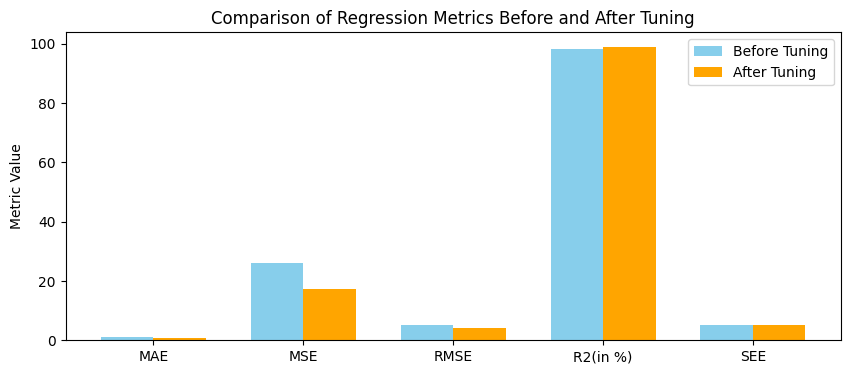

In [99]:
# Metrics
metrics = ['MAE', 'MSE', 'RMSE', 'R2(in %)', 'SEE']
before_values = [mae_11, mse_11, rmse_11, r2_11*100, see_11]
after_values  = [mae_12, mse_12, rmse_12, r2_12*100, see_12]

x = np.arange(len(metrics))  # label positions
width = 0.35  # width of bars

plt.figure(figsize=(10,4))
plt.bar(x - width/2, before_values, width, label='Before Tuning', color='skyblue')
plt.bar(x + width/2, after_values, width, label='After Tuning', color='orange')
plt.xticks(x, metrics)
plt.ylabel('Metric Value')
plt.title('Comparison of Regression Metrics Before and After Tuning')
plt.legend()
plt.show()

In [100]:
# REGULARIZATION TECHNIQUE
from sklearn.linear_model import Ridge


# Create Ridge model
ridge = Ridge(alpha=1.0)  # alpha is the regularization strength

# Train the model
ridge.fit(x_train, y_train)

# Predictions
y_train_r = ridge.predict(x_train)
y_test_r = ridge.predict(x_test)

# Evaluation
print("Ridge Regression MAE (train):", mean_absolute_error(y_train, y_train_r))
print("Ridge Regression MAE(test):", mean_absolute_error(y_test, y_test_r))
print("Ridge Regression r2 (test):", r2_score(y_test, y_test_r))


Ridge Regression MAE (train): 16.306509868423433
Ridge Regression MAE(test): 16.557448159521645
Ridge Regression r2 (test): 0.6677935446603902


In [101]:
train_mae = (mean_absolute_error(y_train,y_train_r))
test_mae = (mean_absolute_error(y_test,y_test_r))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 16.306509868423433
Test MAE: 16.557448159521645
Model is balanced.


In [321]:
# Hyperparameter tuning
param_ridge= {'alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 500, 1000],'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
gc_ridge=GridSearchCV(estimator=ridge,param_grid=param_ridge,cv=5)
gc_ridge.fit(x_train,y_train)
print(gc_ridge.best_params_)

{'alpha': 0.001, 'solver': 'saga'}


In [102]:
# after hyperparameter tuning
ridge_tuned=Ridge(alpha=0.001,solver="sag")
ridge_tuned.fit(x_train,y_train)
ridge_tuned_test=ridge_tuned.predict(x_test)
ridge_tuned_train=ridge_tuned.predict(x_train)

In [103]:
#evaluatiom after tuning
mae_14 = mean_absolute_error(y_test, ridge_tuned_test)
mse_14 = mean_squared_error(y_test, ridge_tuned_test)
rmse_14 = np.sqrt(mse_14)
r2_14= r2_score(y_test, ridge_tuned_test)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - ridge_tuned_test) ** 2)
see_14 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_14)
print("MSE:", mse_14)
print("RMSE:", rmse_14)
print("R2 Score:", r2_14)
print("Standard Error of Estimate (SEE):", see_14)


----- REGRESSION METRICS -----
MAE: 16.558591671482514
MSE: 527.043203547679
RMSE: 22.957421535261293
R2 Score: 0.6677964891199709
Standard Error of Estimate (SEE): 22.991536437894236


In [104]:
train_mae = (mean_absolute_error(y_train,ridge_tuned_train))
test_mae = (mean_absolute_error(y_test,ridge_tuned_test))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 16.307376830634368
Test MAE: 16.558591671482514
Model is balanced.


In [105]:
from sklearn.linear_model import Lasso

# Create Lasso model
lasso = Lasso(alpha=0.01)  # alpha is the regularization strength

# Train the model
lasso.fit(x_train, y_train)

# Predictions
y_train_l = lasso.predict(x_train)
y_test_l = lasso.predict(x_test)

# Evaluation
print("Lasso Regression MAE(train):", mean_absolute_error(y_train, y_train_l))
print("Lasso Regression MAE(test):", mean_absolute_error(y_test, y_test_l))
print("Lasso Regression r2 (test):", r2_score(y_test, y_test_l))


Lasso Regression MAE(train): 16.30375976245227
Lasso Regression MAE(test): 16.554342273360675
Lasso Regression r2 (test): 0.667790016276385


In [106]:
train_mae = (mean_absolute_error(y_train,y_train_l))
test_mae = (mean_absolute_error(y_test,y_test_l))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 16.30375976245227
Test MAE: 16.554342273360675
Model is balanced.


In [107]:
# Hyperparameter tuning

param_lasso= {
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'max_iter': [1000, 5000, 10000]  # number of iterations for convergence
}

gc_lasso=GridSearchCV(estimator=lasso,param_grid=param_lasso,cv=5)
gc_lasso.fit(x_train,y_train)
print(gc_lasso.best_params_)

{'alpha': 0.0001, 'max_iter': 1000}


In [108]:
# after hyperparameter tuning
lasso_tuned=Ridge(alpha=0.0001,max_iter=1000)
lasso_tuned.fit(x_train,y_train)
lasso_tuned_test=lasso_tuned.predict(x_test)
lasso_tuned_train=lasso_tuned.predict(x_train)

In [109]:
#evaluatiom after tuning
mae_16 = mean_absolute_error(y_test, lasso_tuned_test)
mse_16 = mean_squared_error(y_test, lasso_tuned_test)
rmse_16 = np.sqrt(mse_16)
r2_16= r2_score(y_test, lasso_tuned_test)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - lasso_tuned_test) ** 2)
see_16 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_16)
print("MSE:", mse_16)
print("RMSE:", rmse_16)
print("R2 Score:", r2_16)
print("Standard Error of Estimate (SEE):", see_16)


----- REGRESSION METRICS -----
MAE: 16.558593987166763
MSE: 527.0437970403502
RMSE: 22.957434461201238
R2 Score: 0.6677961150323293
Standard Error of Estimate (SEE): 22.99154938304223


In [110]:
train_mae = (mean_absolute_error(y_train,lasso_tuned_train))
test_mae = (mean_absolute_error(y_test,lasso_tuned_test))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 16.307319962238324
Test MAE: 16.558593987166763
Model is balanced.


In [111]:
# ADA BOOST REGRESSOR
from sklearn.ensemble import AdaBoostRegressor
ad=AdaBoostRegressor(random_state=42)
ad.fit(x_train,y_train)
y_train_ad = ad.predict(x_train)
y_test_ad = ad.predict(x_test)
mae_17=mean_absolute_error(y_test, y_test_ad)
mse_17 = mean_squared_error(y_test, y_test_ad)
rmse_17 = np.sqrt(mse_17)
r2_17= r2_score(y_test, y_test_ad)
print(" MAE(train):", mean_absolute_error(y_train, y_train_ad))
print(" MAE(test):", mean_absolute_error(y_test, y_test_ad))
print(" r2 (test):", r2_score(y_test, y_test_ad))
print("MSE",mse_17)
print("RMSE",rmse_17)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - y_test_ad) ** 2)
see_17= np.sqrt(ssr / (n - k - 1))
print("Standard error of estimate :",see_17)

 MAE(train): 19.32649033186763
 MAE(test): 19.57902240706744
 r2 (test): 0.6182709529670614
MSE 605.6158145423661
RMSE 24.609262779335065
Standard error of estimate : 24.645832330593077


In [112]:
train_mae = (mean_absolute_error(y_train,y_train_ad))
test_mae = (mean_absolute_error(y_test,y_test_ad))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 19.32649033186763
Test MAE: 19.57902240706744
Model is balanced.


In [ ]:
# Hyperparameter tuning
param_ad= {"n_estimators":[50,100,150,300],"loss" : ['linear', 'square', 'exponential'],"learning_rate":[0.5,1]}
gc_ad=GridSearchCV(estimator=ad,param_grid=param_ad,cv=5)
gc_ad.fit(x_train,y_train)
print(gc_ad.best_params_)

In [119]:
# AFTER TUNING
ad_tuned=AdaBoostRegressor(estimator=dt_tuned,n_estimators=150,loss="linear",learning_rate=0.5,random_state=42)
ad_tuned.fit(x_train,y_train)
ad_tuned_train = ad_tuned.predict(x_train)
ad_tuned_test = ad_tuned.predict(x_test)
print(" MAE(train):", mean_absolute_error(y_train, ad_tuned_train))
print(" MAE(test):", mean_absolute_error(y_test, ad_tuned_test))
print(" r2 (test):", r2_score(y_test, ad_tuned_test))
print(ad_tuned_test[:10])

 MAE(train): 2.396924472313478
 MAE(test): 2.7323631663950523
 r2 (test): 0.9808880168899828
[172.         156.73333333 186.78787879 167.         158.29508197
 147.12871287 124.         192.         180.88690476 174.        ]


In [114]:
#evaluatiom after tuning
mae_18 = mean_absolute_error(y_test, ad_tuned_test)
mse_18 = mean_squared_error(y_test, ad_tuned_test)
rmse_18 = np.sqrt(mse_18)
r2_18= r2_score(y_test, ad_tuned_test)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - ad_tuned_test) ** 2)
see_18 = np.sqrt(ssr / (n - k - 1))

print("----- REGRESSION METRICS -----")
print("MAE:", mae_18)
print("MSE:", mse_18)
print("RMSE:", rmse_18)
print("R2 Score:", r2_18)
print("Standard Error of Estimate (SEE):", see_18)

----- REGRESSION METRICS -----
MAE: 2.7323631663950523
MSE: 30.321295454611395
RMSE: 5.50647759049389
R2 Score: 0.9808880168899828
Standard Error of Estimate (SEE): 5.514660257983863


In [115]:
train_mae = (mean_absolute_error(y_train,ad_tuned_train))
test_mae = (mean_absolute_error(y_test,ad_tuned_test))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 2.396924472313478
Test MAE: 2.7323631663950523
Model is balanced.


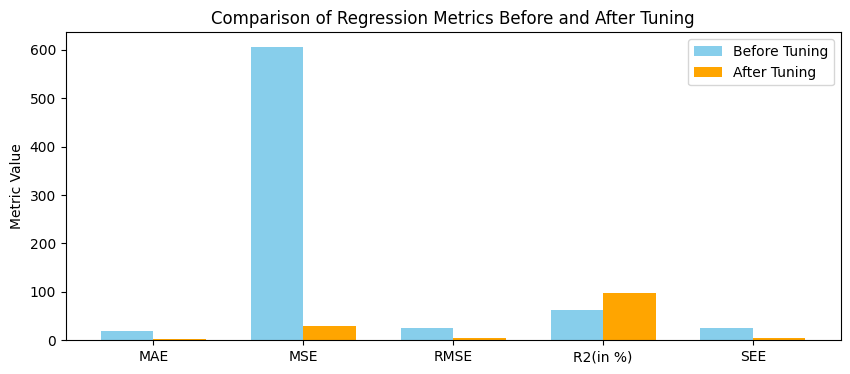

In [116]:
# Metrics
metrics = ['MAE', 'MSE', 'RMSE', 'R2(in %)', 'SEE']
before_values = [mae_17, mse_17, rmse_17, r2_17*100, see_17]
after_values  = [mae_18, mse_18, rmse_18, r2_18*100, see_18]

x = np.arange(len(metrics))  # label positions
width = 0.35  # width of bars

plt.figure(figsize=(10,4))
plt.bar(x - width/2, before_values, width, label='Before Tuning', color='skyblue')
plt.bar(x + width/2, after_values, width, label='After Tuning', color='orange')
plt.xticks(x, metrics)
plt.ylabel('Metric Value')
plt.title('Comparison of Regression Metrics Before and After Tuning')
plt.legend()
plt.show()

In [117]:
# Comparing different algorithms 
compare= {
    "Algorithm": ["Linear Regression(U)","DecisionTree(B)","Random Forest(B)", "K nearest Neighbour(O)","XGBooster(B)","Ridge(U)","Lasso(U)","ADABosster(B)"],
    "MAE":  [mae_2,mae_4,mae_6,mae_12,mae_8,mae_14,mae_16,mae_18],
    "MSE":  [mse_2,mse_4,mse_6,mse_12,mse_8,mse_14,mse_16,mse_18],
    "RMSE": [rmse_2,rmse_4,rmse_6,rmse_12,rmse_8,rmse_14,rmse_16,rmse_18],
    "R2":   [r2_2,r2_4,r2_6,r2_12,r2_8,r2_14,r2_16,r2_18],
}

comparision = pd.DataFrame(compare)
print(comparision)


                Algorithm        MAE         MSE       RMSE        R2
0    Linear Regression(U)  16.558594  527.043797  22.957434  0.667796
1         DecisionTree(B)   6.464891  143.241035  11.968335  0.909713
2        Random Forest(B)   6.542942  108.087489  10.396513  0.931871
3  K nearest Neighbour(O)   0.770258   17.280262   4.156953  0.989108
4            XGBooster(B)  16.034468  499.917999  22.358846  0.684894
5                Ridge(U)  16.558592  527.043204  22.957422  0.667796
6                Lasso(U)  16.558594  527.043797  22.957434  0.667796
7           ADABosster(B)   2.732363   30.321295   5.506478  0.980888


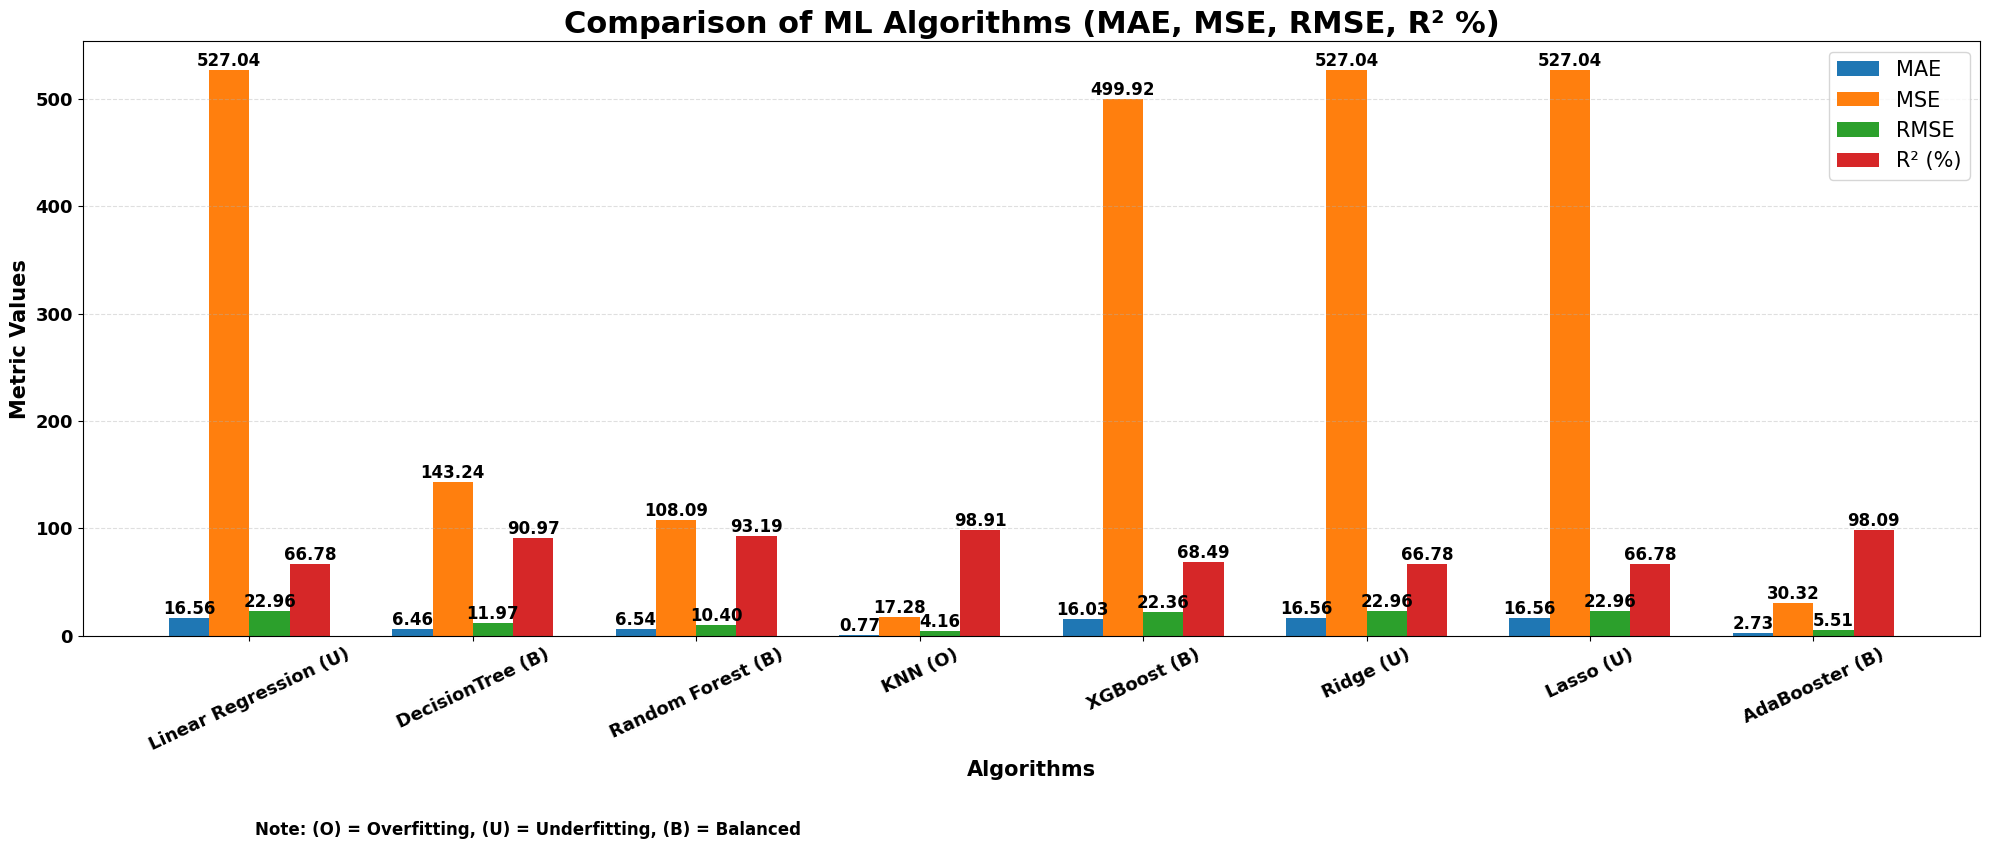

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


Algorithm = [
    "Linear Regression (U)",
    "DecisionTree (B)",
    "Random Forest (B)",
    "KNN (O)",
    "XGBoost (B)",
    "Ridge (U)",
    "Lasso (U)",
    "AdaBooster (B)"
]

MAE  = [mae_2, mae_4, mae_6, mae_12, mae_8, mae_14, mae_16, mae_18]
MSE  = [mse_2, mse_4, mse_6, mse_12, mse_8, mse_14, mse_16, mse_18]
RMSE = [rmse_2, rmse_4, rmse_6, rmse_12, rmse_8, rmse_14, rmse_16, rmse_18]
R2   = [r2_2*100, r2_4*100, r2_6*100, r2_12*100, r2_8*100, r2_14*100, r2_16*100, r2_18*100]


x = np.arange(len(Algorithm))
width = 0.18

plt.figure(figsize=(20,8))

bars1 = plt.bar(x - 1.5*width, MAE,  width, label='MAE')
bars2 = plt.bar(x - 0.5*width, MSE,  width, label='MSE')
bars3 = plt.bar(x + 0.5*width, RMSE, width, label='RMSE')
bars4 = plt.bar(x + 1.5*width, R2,   width, label='R² (%)')


# Adding labels to bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f"{height:.2f}",
            ha='center', va='bottom',
            fontsize=12, fontweight='bold'
        )

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)


# Styling
plt.xticks(x, Algorithm, rotation=25, fontsize=13, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.xlabel("Algorithms", fontsize=15, fontweight='bold')
plt.ylabel("Metric Values", fontsize=15, fontweight='bold')

plt.title("Comparison of ML Algorithms (MAE, MSE, RMSE, R² %)",
          fontsize=22, fontweight='bold')

plt.legend(fontsize=15)
plt.grid(axis="y", linestyle="--", alpha=0.4)


plt.figtext(0.13, -0.05, 
            "Note: (O) = Overfitting, (U) = Underfitting, (B) = Balanced", 
            fontsize=12, fontweight='bold', ha='left')


plt.tight_layout()

plt.show()


In [220]:
# Ensemble techniques
# best model till now KNN,Ada booster
# stacking
from sklearn.ensemble import VotingRegressor
voting_reg = VotingRegressor(
    estimators=[('dt_tuned', dt_tuned), ('ad', ad_tuned)],
    weights=[0.7, 0.5]   
)

# Train the ensemble
voting_reg.fit(x_train, y_train)

# Make predictions
y_test_v = voting_reg.predict(x_test)
y_train_v = voting_reg.predict(x_train)

mae_19=mean_absolute_error(y_test, y_test_v)
mse_19 = mean_squared_error(y_test, y_test_v)
rmse_19 = np.sqrt(mse_19)
r2_19= r2_score(y_test, y_test_v)
print(" MAE(train):", mean_absolute_error(y_train, y_train_v))
print(" MAE(test):", mean_absolute_error(y_test, y_test_v))
print(" r2 (test):", r2_score(y_test, y_test_v))
print("MSE",mse_19)
print("RMSE",rmse_19)
# Standard Error of Estimate (SEE)
n = len(y_test)
k = x_test.shape[1]
ssr = np.sum((y_test - y_test_v) ** 2)
see_19= np.sqrt(ssr / (n - k - 1))
print("Standard error of estimate :",see_19)

 MAE(train): 4.229465465629779
 MAE(test): 4.683177874327976
 r2 (test): 0.9560710665919709
MSE 69.693561427054
RMSE 8.348266971477013
Standard error of estimate : 8.360672559554418


In [221]:
train_mae = (mean_absolute_error(y_train,y_train_v))
test_mae = (mean_absolute_error(y_test,y_test_v))
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
if train_mae < test_mae * 0.7:
    print("Model is OVERFITTING (High Variance).")
elif train_mae > test_mae:
    print("Model is UNDERFITTING (High Bias).")
else:
    print("Model is balanced.")

Train MAE: 4.229465465629779
Test MAE: 4.683177874327976
Model is balanced.


In [128]:
delivery_df.head()

,batting_team,bowling_team,current_score,balls_bowled,wickets_left,runs_last_3_overs,crr,city,runs_y
392,1,4,12,18,9,12,4.00,30,141
393,1,4,18,19,9,18,5.68,30,141
394,1,4,18,20,9,18,5.40,30,141
395,1,4,19,21,9,18,5.43,30,141
396,1,4,19,22,9,17,5.18,30,141


In [131]:
# Best model till now is voting regressor with combination of KNeearestNeighbours and ada booster with tuning
# Pipelining
from sklearn.preprocessing import  OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
categorical_cols = ['batting_team', 'bowling_team', 'city']
numeric_cols = ['current_score', 'balls_bowled', 'wickets_left', 'runs_last_3_overs', 'crr']


In [146]:
categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(
transformers=[
('num', numeric_transformer, numeric_cols),
('cat', categorical_transformer, categorical_cols)
]
)

In [203]:
voting_model = VotingRegressor(
estimators=[("dt",dt_tuned), ('ada', ad_tuned)],
weights=[0.5, 0.7]
)


In [204]:
pipeline = Pipeline(steps=[
('preprocessor', preprocessor),
('regressor', voting_model)
])

In [205]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['current_score',
                                                   'balls_bowled',
                                                   'wickets_left',
                                                   'runs_last_3_overs',
                                                   'crrr']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('regressor',
                 VotingRegressor(estimators=[('dt',
                                              DecisionTreeRegressor(max_depth=9,
                                                                    min_samples_split=4)),
                                             ('ada',
                                              AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=9,
                                                                                                min_samples_split=4),
                                                                learning_rate=0.5,
                                                                n_estimators=150,
                                                                random_state=42))],
                                 weights=[0.5, 0.7]))])

In [206]:
import pandas as pd

x_train = pd.DataFrame(x_train, columns=numeric_cols + categorical_cols)
x_test = pd.DataFrame(x_test, columns=numeric_cols + categorical_cols)


In [207]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['current_score',
                                                   'balls_bowled',
                                                   'wickets_left',
                                                   'runs_last_3_overs',
                                                   'crrr']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('regressor',
                 VotingRegressor(estimators=[('dt',
                                              DecisionTreeRegressor(max_depth=9,
                                                                    min_samples_split=4)),
                                             ('ada',
                                              AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=9,
                                                                                                min_samples_split=4),
                                                                learning_rate=0.5,
                                                                n_estimators=150,
                                                                random_state=42))],
                                 weights=[0.5, 0.7]))])

In [208]:
y_pred = pipeline.predict(x_test)

In [209]:
y_pred

array([159.41666667, 158.54166667, 120.38888889, ..., 145.41666667,
       119.08333333, 154.55555556], shape=(3035,))

In [222]:
print("First 5 true values of x_test targets:")
print(y_test.head(5))

# Check first few predicted values
print("First 5 predicted values:")
print(y_pred[:5])

First 5 true values of x_test targets:
9733     160
17463    153
840      185
18178    167
11664    152
Name: runs_y, dtype: int64
First 5 predicted values:
[159.41666667 158.54166667 120.38888889 149.5        113.38888889]


In [217]:
import pickle

# Save the trained pipeline
with open('cricket_pipeline_bits.pkl', 'wb') as f:
    pickle.dump(pipeline, f)